In [1]:
import pandas as pd
import os
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from scipy.io import wavfile

2025-01-23 16:04:42.048565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 16:04:42.066449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737677082.088396  618652 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737677082.094820  618652 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 16:04:42.116909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data_folder = "/home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/"
meta_file = "nn_ele_hb_00-24hr_TrainingSet.txt"

In [3]:
data = pd.read_csv(os.path.join(data_folder, meta_file), delimiter='\t')
len(data)

3240

# Distribution of the Length of the Labeled Signals

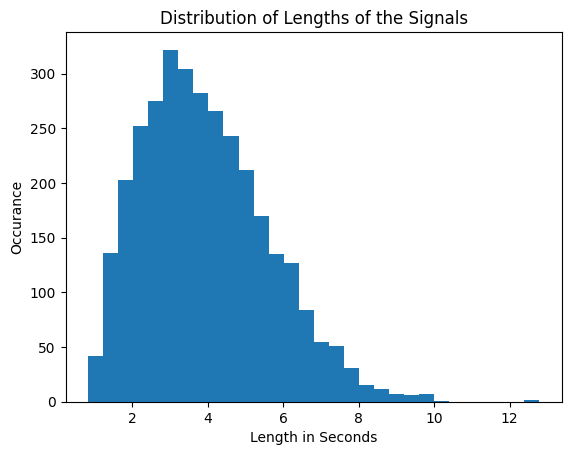

In [4]:
lengths = data['End Time (s)'] - data['Begin Time (s)']
plt.hist(lengths, bins=30)
plt.xlabel("Length in Seconds")
plt.ylabel("Occurance")
plt.title("Distribution of Lengths of the Signals")
plt.show()

5 second window
0 - 512 hz

less than 3 seconds might be an issue
low power signals

Use select windows for positive examples
exclue selection windows then capture clear examples.

tune spectrogram

# Distribution of Low and High Frequency Ranges

Text(0, 0.5, 'Occurance')

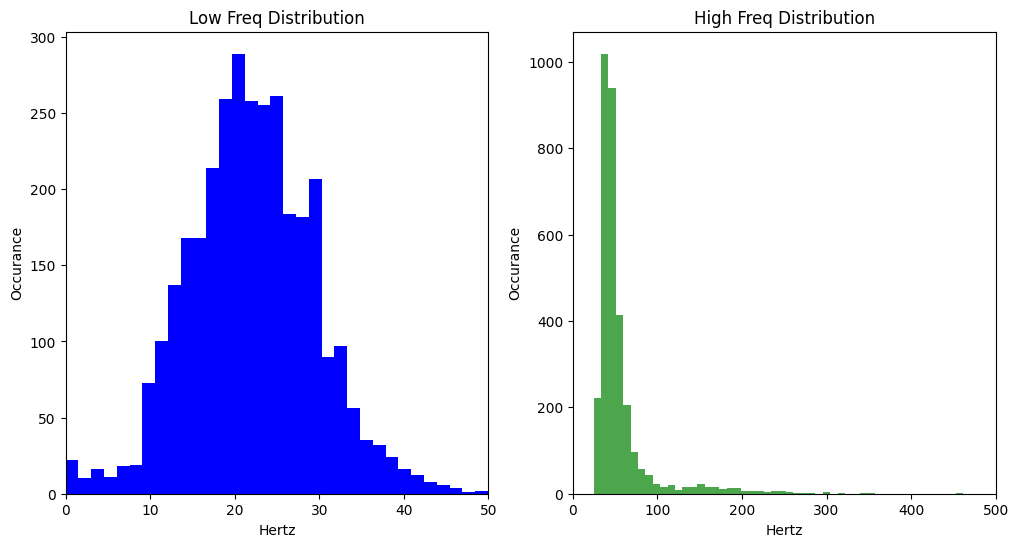

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms
ax1.hist(data['Low Freq (Hz)'], bins=50, color='blue')
ax1.set_title('Low Freq Distribution')
ax1.set_xlim([0, 50])
ax1.set_xlabel('Hertz')
ax1.set_ylabel('Occurance')

ax2.hist(data['High Freq (Hz)'], bins=50, alpha=0.7, color='green')
ax2.set_title('High Freq Distribution')
ax2.set_xlim([0, 500])
ax2.set_xlabel('Hertz')
ax2.set_ylabel('Occurance')

In [11]:
from scipy.signal import butter, lfilter, resample

def down_sample(audio, input_sr, output_sr):
    """
    input:
        audio: 1D vector
        input_sr: sampling rate (hz)
        output_sr: target sampling rate (hz)

    output:
        1D vector of down sampled audio    
    """
    if input_sr <= output_sr:
        return audio

    num_samples = int(len(audio) * float(output_sr)/ input_sr)
    down_sampled_audio = resample(audio, num_samples)

    return down_sampled_audio

def normalize_audio(audio):
    audio = tf.cast(audio, tf.float32)
    mean = tf.reduce_mean(audio)
    stddev = tf.math.reduce_std(audio)
    normalized_audio = (audio - mean) / stddev
    return normalized_audio

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def stft_hann_window(audio, frame_length, frame_step):
    stft = tf.signal.stft(
        audio,
        frame_length=frame_length,
        frame_step=frame_step,
        window_fn=tf.signal.hann_window
    )

    return tf.math.log(tf.abs(stft) + 1e-10).numpy().T


In [12]:
sample_length = 5 # seconds
low_freq = 0 # hz
high_freq = 512 # hz
target_sr = 4000 # hz
frame_length = 2048
frame_step = 200    # Smaller is for better time resolution but greater data size

In [13]:
frequency_resolution = target_sr / frame_length
print(frequency_resolution)

1.953125


Opening file: /home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/nn01a_20180126_000000.wav


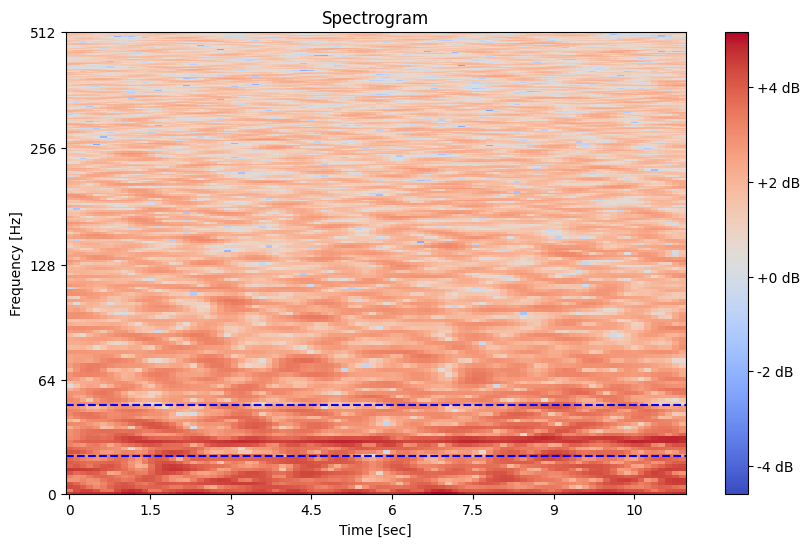

(1025, 90)


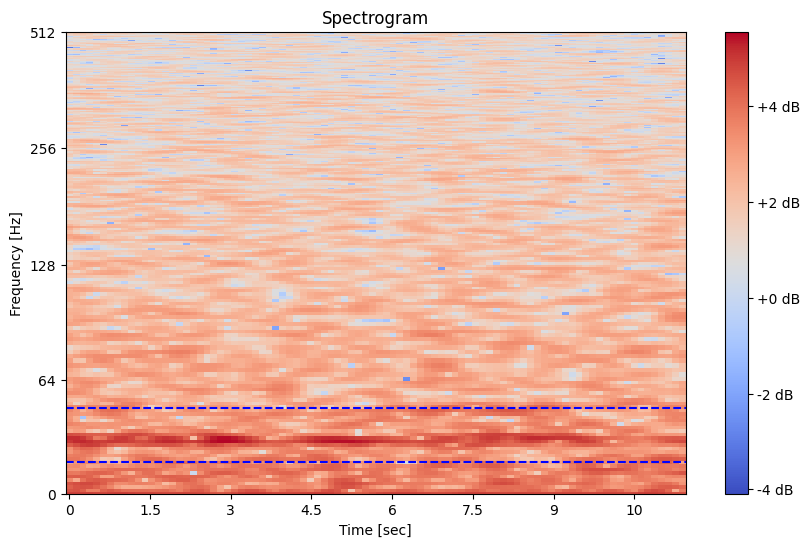

(1025, 90)


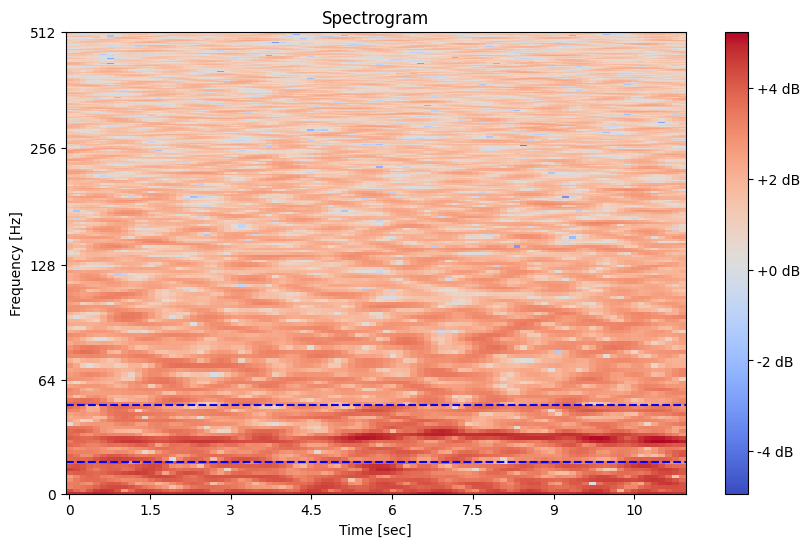

(1025, 90)


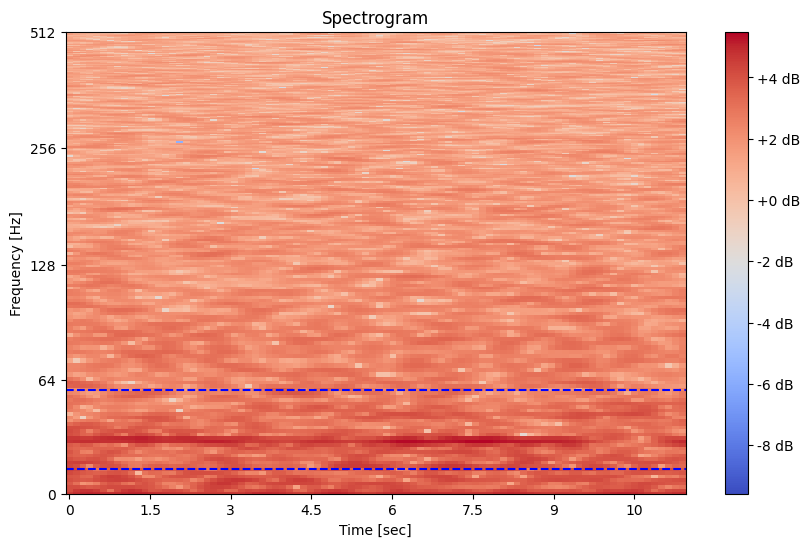

(1025, 90)


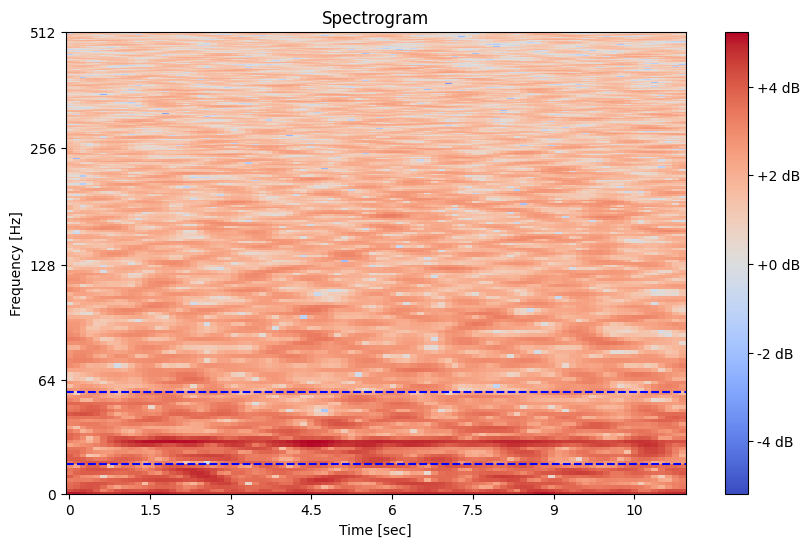

(1025, 90)


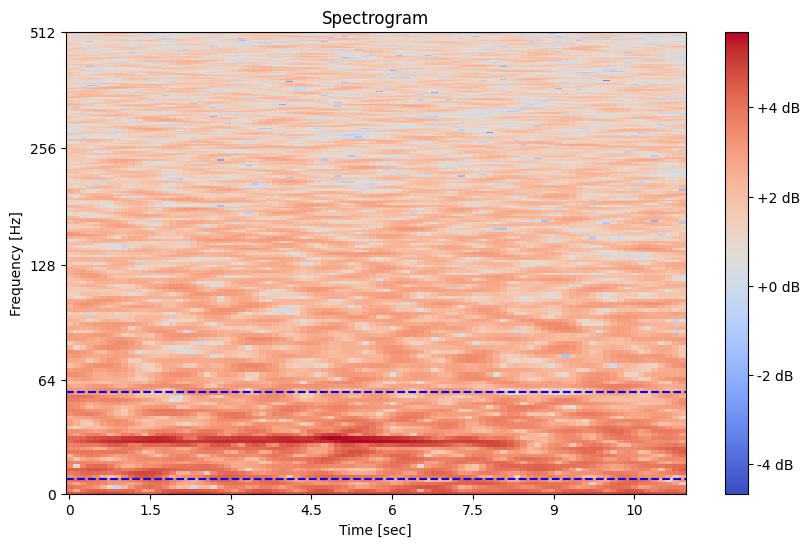

(1025, 90)


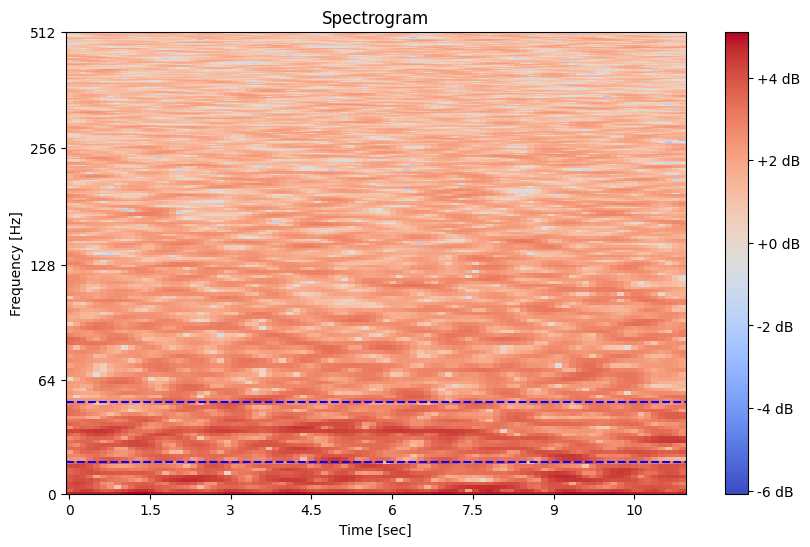

(1025, 90)


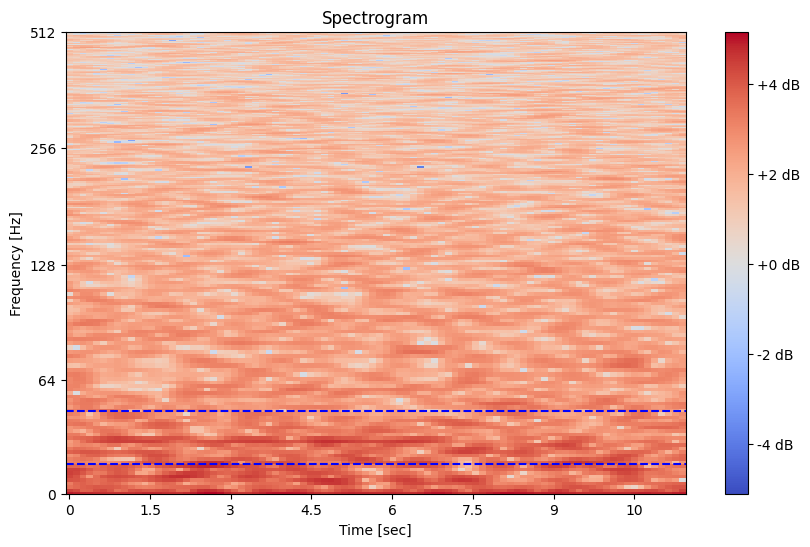

(1025, 90)


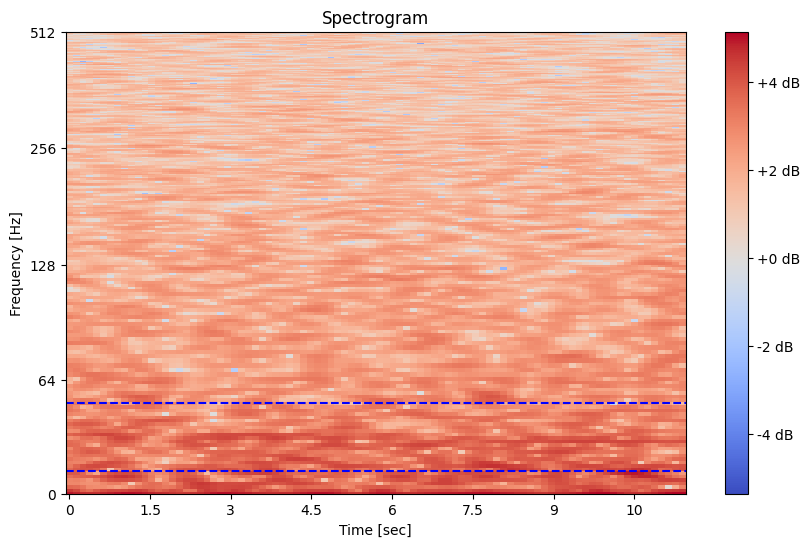

(1025, 90)


In [18]:
for file in set(data['Begin File']):
    target_file = os.path.join(data_folder, file)

    if os.path.exists(target_file):
        print(f"Opening file: {target_file}")

        sampling_rate, audio = wavfile.read(target_file)
        audio = normalize_audio(audio)

        clips = data[data['Begin File'] == file]

        for offset, start, stop, low, high in zip(clips['File Offset (s)'], clips['Begin Time (s)'], clips['End Time (s)'], clips['Low Freq (Hz)'], clips['High Freq (Hz)']):
            
            # Clip the audio
            starting_pos = int(offset)
            stopping_pos = int(offset) + sample_length

            begin_index, end_index = int(starting_pos * sampling_rate), int(stopping_pos * sampling_rate)
            audio_clip = audio[begin_index: end_index]

            # Process
            audio_clip = down_sample(audio_clip, sampling_rate, target_sr)
            #audio_clip = lowpass_filter(audio_clip, high_freq, target_sr)
            stft = stft_hann_window(audio_clip, frame_length=frame_length, frame_step=frame_step)

            # Display the spectrogram with upper and low bounds as specified in the selection table.
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(stft, sr=target_sr, x_axis="time", y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            plt.xlabel('Time [sec]')
            plt.ylabel('Frequency [Hz]')
            plt.ylim(0, 512)  # Set the y-axis limit to show frequencies under 100 Hz
            plt.axhline(y=low, color='blue', linestyle='--', label=f'Low Freq: {low} Hz')
            plt.axhline(y=high, color='blue', linestyle='--', label=f'High Freq: {high} Hz')
            plt.show()
            
            print(stft.shape)